In [1]:
import os
import gc
import ot
import pickle
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.stats import spearmanr, pearsonr
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

import plotly

import commot as ct

plotly_colors = plotly.colors.qualitative.Alphabet

In [2]:
def plot_cluster(X, labels, colors, s=2, filename=None, legend=False, legend_markerscale=1.0):
    unique_labels = np.sort(list(set(list(labels))))
    cnt = 0
    for label in unique_labels:
        idx = np.where(labels == label)[0]
        plt.scatter(X[idx,0], X[idx,1], s=s, c=colors[cnt], label=label, linewidth=0)
        cnt += 1
    plt.axis('off')
    plt.axis('equal')
    if legend:
        plt.legend(markerscale=legend_markerscale, loc=[1.0,0.0])
    if not filename is None:
        plt.tight_layout()
        plt.savefig(filename)

## **Visualize cell types**

In [3]:
adata = sc.read_h5ad("./data/adata.h5ad")

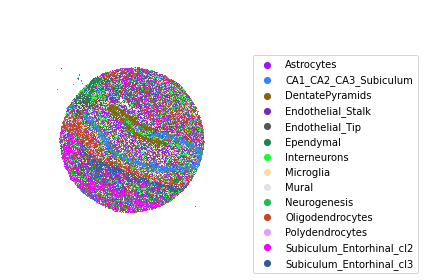

In [4]:
pts = adata.obsm['spatial']
labels = np.array( adata.obs['cluster'] )
plot_cluster(pts, labels, plotly.colors.qualitative.Alphabet, s=0.8, legend=True, legend_markerscale=8, filename='./figure/clustering_celltype.pdf')

## **Cluster spots based on signaling activity**

In [54]:
X_r = adata.obsm['commot-cellchat-sum-receiver'].values
colname_r = list( adata.obsm['commot-cellchat-sum-receiver'].columns.values )
X_s = adata.obsm['commot-cellchat-sum-sender'].values
colname_s = list( adata.obsm['commot-cellchat-sum-sender'].columns.values )
X_signal = np.concatenate( (X_r, X_s), axis=1 )
colname = colname_r + colname_s
adata_signal = anndata.AnnData(X=X_signal, var=pd.DataFrame(index=colname))

In [55]:
sc.tl.pca(adata_signal, svd_solver='arpack')
sc.pp.neighbors(adata_signal, n_neighbors=20, n_pcs=20)
sc.tl.leiden(adata_signal, resolution=0.2)

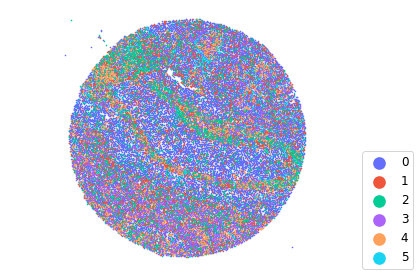

In [56]:
pts = adata.obsm['spatial']
labels = np.array( adata_signal.obs['leiden'], int )
plot_cluster(pts, labels, plotly.colors.qualitative.Plotly, s=2.5, legend=True, legend_markerscale=8, filename='./figure/clustering_ccc.pdf')

In [57]:
for i in range(labels.max()+1):
    idx = np.where(labels==i)[0]
    plt.scatter(pts[idx,0], pts[idx,1], c=plotly.colors.qualitative.Plotly[i], s=0.3)
    plt.axis('off')
    plt.axis('equal')
    plt.savefig('./figure/ccc_based_clustering/scatter_label_%d.pdf' % i)
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [58]:
sc.tl.rank_genes_groups(adata_signal, 'leiden', method='wilcoxon')

categories: 0, 1, 2, etc.
var_group_labels: 1, 2


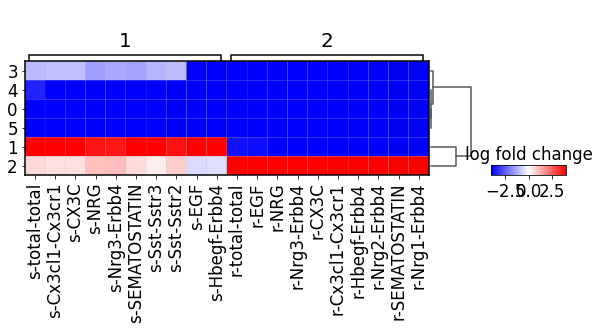

categories: 0, 1, 2, etc.
var_group_labels: 1, 2


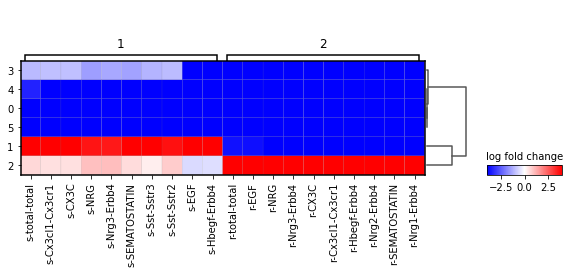

In [60]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 20

sc.pl.rank_genes_groups_matrixplot(
    adata_signal,
    n_genes=10,
    values_to_plot="logfoldchanges",
    cmap='bwr',
    vmin=-4,
    vmax=4,
    min_logfoldchange=3,
    colorbar_title='log fold change',
    groupby='leiden',
    save='ccc_cluster_bigfont.pdf'
)

mpl.rcParams['font.size'] = 12
sc.pl.rank_genes_groups_matrixplot(
    adata_signal,
    n_genes=10,
    values_to_plot="logfoldchanges",
    cmap='bwr',
    vmin=-4,
    vmax=4,
    min_logfoldchange=3,
    colorbar_title='log fold change',
    groupby='leiden',
    save='ccc_cluster_smallfont.pdf'
)